### Ajuste de parámetros mediante validación cruzada

Imports:

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
from time import time
import shutil

Carga de datos, MNIST:

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
mean_img = train_images.mean(axis=0)
train_images = train_images - mean_img
test_images = test_images - mean_img

Reduzco mucho el tamaño del conjunto de entrenamiento, para que las pruebas vayan más rápido:

In [4]:
# Numero de ejemplos para entrenamiento
num_train = 5000

# Seleccionamos imagenes para training
tr_images = train_images[:num_train]
tr_labels = train_labels[:num_train]
print(tr_images.shape)
print(tr_labels.shape)

(5000, 28, 28)
(5000,)


Validación de un modelo:

Usamos la clase ``StratifiedKFold`` (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) de ``scikitlearn``, que genera índices para entrenamiento y validación de acuerdo a una estrategia de validación cruzada con k folds. 

En el siguiente ejemplo se usa ``k = 5``:


In [5]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True)
# kfold.split(...) devuelve un generador que genera los índices de entrenamiento
# y test para cada una de las particiones

cvscores = []
for itrain, itest in kfold.split(tr_images, tr_labels):
    # Creamos el modelo:
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(1.0)))
    model.add(keras.layers.Dense(10, activation="softmax"))

    # Lo compilamos:
    model.compile(optimizer=keras.optimizers.Adam(0.001), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])    
    
    # Lo entrenamos:
    nepochs = 30
    history = model.fit(tr_images[itrain], 
                        tr_labels[itrain], 
                        epochs=nepochs,
                        verbose=0,
                        batch_size=50)    
    
    # Lo evaluamos:
    loss, acc = model.evaluate(tr_images[itest], tr_labels[itest], verbose=0)
    
    print("Accuracy: %.2f%%" % (acc*100.0))
    cvscores.append(acc * 100.)
print("%.2f%% \u00B1 %.2f%%" % (np.mean(cvscores), np.std(cvscores)))

Accuracy: 89.80%
Accuracy: 90.70%
Accuracy: 88.50%
Accuracy: 89.70%
Accuracy: 89.90%
89.72% ± 0.71%


A continuación definimos algunas funciones para simplificar la tarea.

Esta función crea una red neuronal con ``nhidden`` neuronas ocultas y constante de regularización ``lreg``:

In [6]:
def create_model(nhidden, lreg):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(nhidden, activation="relu", kernel_regularizer=keras.regularizers.l2(lreg)))
    model.add(keras.layers.Dense(10, activation="softmax"))

    return model

Esta función evalúa un modelo haciendo validación cruzada: 

In [7]:
def xvalidation(x, y, nhidden, lreg, lrate, num_epochs, bsize, nfolds, semilla):

    kfold = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=semilla)
    cvscores = np.zeros(nfolds)
    for i, (train, test) in enumerate(kfold.split(x, y)):
        model = create_model(nhidden, lreg)
        model.compile(optimizer=keras.optimizers.Adam(lrate), 
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'])    
    
        history = model.fit(x[train], 
                            y[train], 
                            epochs=num_epochs,
                            verbose=0,
                            batch_size=bsize)    
    
        loss, acc = model.evaluate(x[test], y[test], verbose=0)
    
        cvscores[i] = acc
    return cvscores

En la función anterior, ¿por qué se crea el ``StratifiedKFold`` pasando como argumento ``random_state=semilla``?

Búsqueda del número de neuronas y la constante de regularización:

In [8]:
for nhidden in [32, 64]:
  for lreg in [1.0, 0.1, 0.01, 0.001]:
      cvscores = xvalidation(tr_images, tr_labels, nhidden, lreg, 0.001, 30, 50, 5, 13)
      print("nhidden = %d" % (nhidden))
      print("lreg = %f" % (lreg))
      print(cvscores)
      print("   %.2f%% \u00B1 %.2f%%" % (100*np.mean(cvscores), 100*np.std(cvscores)))

nhidden = 32
lreg = 1.000000
[0.903      0.884      0.89700001 0.90700001 0.90200001]
   89.86% ± 0.80%
nhidden = 32
lreg = 0.100000
[0.90700001 0.91799998 0.90799999 0.89700001 0.903     ]
   90.66% ± 0.69%
nhidden = 32
lreg = 0.010000
[0.92000002 0.89499998 0.88099998 0.90799999 0.89899999]
   90.06% ± 1.30%
nhidden = 32
lreg = 0.001000
[0.92000002 0.89399999 0.88200003 0.91399997 0.89099997]
   90.02% ± 1.44%
nhidden = 64
lreg = 1.000000
[0.912      0.90799999 0.88       0.91299999 0.89399999]
   90.14% ± 1.27%
nhidden = 64
lreg = 0.100000
[0.92699999 0.917      0.90100002 0.917      0.921     ]
   91.66% ± 0.86%
nhidden = 64
lreg = 0.010000
[0.92400002 0.92500001 0.90399998 0.94       0.92299998]
   92.32% ± 1.14%
nhidden = 64
lreg = 0.001000
[0.91100001 0.90799999 0.90600002 0.921      0.90899998]
   91.10% ± 0.53%


Elegimos los mejores parámetros de acuerdo a la búsqueda anterior y volvemos a entrenar el modelo con esos parámetros usando todos los datos de entrenamiento:

In [9]:
nhidden = 64
lreg = 0.001

model = create_model(nhidden, lreg)

model.compile(optimizer=keras.optimizers.Adam(0.001), 
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])    
    
history = model.fit(tr_images, 
                    tr_labels, 
                    epochs=30,
                    verbose=0,
                    batch_size=50)  

Y lo aplicamos a los datos de test:

In [10]:
loss, acc = model.evaluate(test_images, test_labels, verbose=0)
print(acc)

0.9168999791145325


**Otras métricas:** ¿Cómo calcular, por ejemplo el ROC-AUC?

Como ejemplo, calculemos la ROC para una de las clases frente al resto:

313/313 [==============================] - 0s 1ms/step


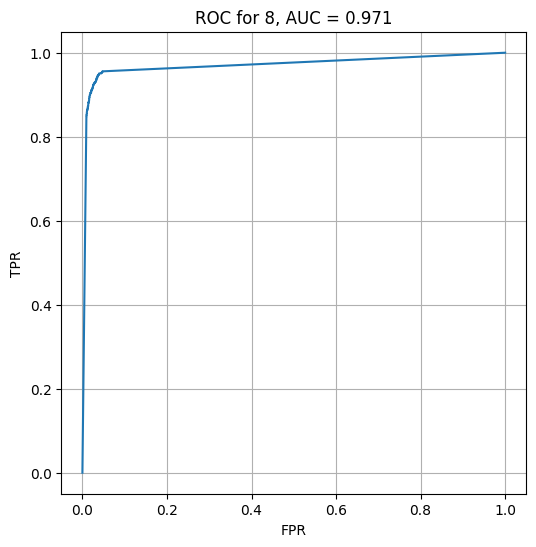

In [11]:
from sklearn import metrics

target = 8
probs = model.predict(test_images)
prob_target = probs[:, target]
ytrue = test_labels == target

fpr, tpr, thresholds = metrics.roc_curve(ytrue, prob_target, pos_label=1)
auc = metrics.roc_auc_score(ytrue, prob_target)
                            
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC for {target}, AUC = {auc:.3f}')
plt.grid(True)
plt.show()

**Ejercicio:** Realizar una validación cruzada utilizando una métrica de evaluación distinta.

Cómo hacer todo esto de una manera más automática:

- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) de ``scikit-learn``.

- Keras Tuner: https://www.tensorflow.org/tutorials/keras/keras_tuner

- HParams dashboard en tensorboard: https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams

### Ejemplo de uso de GridSearchCV:

Usamos ``scikeras``, un wrapper de keras para ``scikit-learn``.

In [13]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

Función para crear el modelo. Devuelve el modelo ya compilado:

In [15]:
def create_model(nhidden, lreg, lrate):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(nhidden, activation="relu", kernel_regularizer=keras.regularizers.l2(lreg)))
    model.add(keras.layers.Dense(10, activation="softmax"))

    model.compile(optimizer=keras.optimizers.Adam(lrate), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])    

    return model

Usamos la clase [KerasClassifier](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasClassifier) para adaptar el modelo al estilo de ``scikit-learn``:

In [16]:
model = KerasClassifier(model=create_model, lreg=1.0, nhidden=50, lrate=0.001)

Ahora podemos usar los métodos típicos de ``scikit-learn``, como ``fit``, ``predict``, ``predict_proba``, ``score``, etc. Por ejemplo:

In [17]:
model.fit(tr_images, tr_labels, epochs=10, batch_size=50)

Epoch 1/10
100/100 [==============================] - 1s 2ms/step - loss: 75.1997 - acc: 0.7324
Epoch 2/10
100/100 [==============================] - 0s 2ms/step - loss: 34.6931 - acc: 0.8922
Epoch 3/10
100/100 [==============================] - 0s 2ms/step - loss: 21.3527 - acc: 0.9206
Epoch 4/10
100/100 [==============================] - 0s 2ms/step - loss: 13.5710 - acc: 0.9320
Epoch 5/10
100/100 [==============================] - 0s 2ms/step - loss: 8.9761 - acc: 0.9396
Epoch 6/10
100/100 [==============================] - 0s 2ms/step - loss: 6.5563 - acc: 0.9230
Epoch 7/10
100/100 [==============================] - 0s 3ms/step - loss: 4.6028 - acc: 0.9434
Epoch 8/10
100/100 [==============================] - 0s 2ms/step - loss: 3.6121 - acc: 0.9374
Epoch 9/10
100/100 [==============================] - 0s 2ms/step - loss: 3.4580 - acc: 0.9270
Epoch 10/10
100/100 [==============================] - 0s 2ms/step - loss: 3.1058 - acc: 0.9332


KerasClassifier(
	model=<function create_model at 0x7efcb1a1b910>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	lreg=1.0
	nhidden=50
	lrate=0.001
	class_weight=None
)

In [18]:
preds = model.predict(tr_images)
print(preds[:10])
probs = model.predict_proba(tr_images)
print(probs[:10])
score = model.score(tr_images, tr_labels)
print(score)

157/157 [==============================] - 0s 1ms/step
[5 0 4 1 9 2 1 3 1 4]
157/157 [==============================] - 0s 1ms/step
[[6.76197365e-32 0.00000000e+00 0.00000000e+00 5.19920639e-15
  0.00000000e+00 9.99999940e-01 0.00000000e+00 1.19147179e-31
  1.47544504e-34 0.00000000e+00]
 [9.99999940e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 2.84863898e-36
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.86119831e-32 1.54044503e-15 9.30464434e-31
  9.99995887e-01 1.54618943e-32 3.37908084e-33 4.09650374e-06
  9.94098468e-35 1.04493025e-20]
 [0.00000000e+00 9.99999940e-01 3.37744503e-18 1.26659417e-38
  7.44220702e-38 0.00000000e+00 3.78632872e-32 9.53136003e-33
  2.44704298e-26 0.00000000e+00]
 [0.00000000e+00 6.96613379e-18 0.00000000e+00 0.00000000e+00
  1.00077166e-04 0.00000000e+00 0.00000000e+00 2.67169715e-24
  1.45432586e-35 9.99899805e-01]
 [0.00000000e+00 1.56934218e-38 9.99999940e-01 2.09472692e-27
  0.00000000e+00 2.42

Y también podemos usar el modelo en un ``GridSearchCV``:

In [19]:
parameters = {'nhidden': [32, 64], 'lreg': [1.0, 0.1, 0.01, 0.001], 'lrate': [0.001]}
model = KerasClassifier(model=create_model, lreg=1.0, nhidden=50, lrate=0.001)

gscv = GridSearchCV(estimator=model, param_grid=parameters, cv=5, scoring='accuracy')
fitted_models = gscv.fit(tr_images, tr_labels, epochs=30, batch_size=50, verbose=0)

32/32 [==============================] - 0s 1ms/step


Resumen y mejores parámetros:

In [20]:
print("Best: %f using %s" % (fitted_models.best_score_, fitted_models.best_params_))
for params, mean_score, std_score in zip(fitted_models.cv_results_['params'], fitted_models.cv_results_['mean_test_score'], fitted_models.cv_results_['std_test_score']):
    print("%f \u00B1 %f with: %r" % (mean_score, std_score, params))

Best: 0.909600 using {'lrate': 0.001, 'lreg': 0.01, 'nhidden': 64}
0.886400 ± 0.017142 with: {'lrate': 0.001, 'lreg': 1.0, 'nhidden': 32}
0.898000 ± 0.012681 with: {'lrate': 0.001, 'lreg': 1.0, 'nhidden': 64}
0.895200 ± 0.006675 with: {'lrate': 0.001, 'lreg': 0.1, 'nhidden': 32}
0.904200 ± 0.006969 with: {'lrate': 0.001, 'lreg': 0.1, 'nhidden': 64}
0.895200 ± 0.007652 with: {'lrate': 0.001, 'lreg': 0.01, 'nhidden': 32}
0.909600 ± 0.015525 with: {'lrate': 0.001, 'lreg': 0.01, 'nhidden': 64}
0.893800 ± 0.014689 with: {'lrate': 0.001, 'lreg': 0.001, 'nhidden': 32}
0.908400 ± 0.011569 with: {'lrate': 0.001, 'lreg': 0.001, 'nhidden': 64}


### Apéndice: checkpointing y early stopping en Keras.

``ModelCheckpoint``: https://keras.io/api/callbacks/model_checkpoint/

Es un callback que sirve para salvar un modelo de Keras durante el entrenamiento, cada cierto número de épocas.

In [21]:
# Modelo:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28), name="entrada"))
model.add(keras.layers.Dense(64, activation="relu", name="oculta"))
model.add(keras.layers.Dense(10, activation="softmax", name="salida"))

# Compile:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])

# Callback a TensorBoard:
cb1 = keras.callbacks.TensorBoard(log_dir='logs/prueba', histogram_freq=1, write_images=True)
cb2 = keras.callbacks.ModelCheckpoint('logs/my_checkpoints.{epoch:02d}-{val_loss:.2f}', monitor="val_loss")
callbacks = [cb1, cb2]

# Entrenamiento del modelo:
history = model.fit(train_images, 
                    train_labels, 
                    epochs=20, 
                    validation_data=(test_images, test_labels),
                    batch_size=50,
                    callbacks=callbacks)

Epoch 1/20
1194/1200 [============================>.] - ETA: 0s - loss: 4.0452 - acc: 0.9001

1200/1200 [==============================] - 6s 5ms/step - loss: 4.0366 - acc: 0.9002 - val_loss: 1.7823 - val_acc: 0.9369
Epoch 2/20
1199/1200 [============================>.] - ETA: 0s - loss: 1.0843 - acc: 0.9483

1200/1200 [==============================] - 4s 3ms/step - loss: 1.0835 - acc: 0.9483 - val_loss: 1.0985 - val_acc: 0.9477
Epoch 3/20
1186/1200 [============================>.] - ETA: 0s - loss: 0.6374 - acc: 0.9592

1200/1200 [==============================] - 4s 3ms/step - loss: 0.6347 - acc: 0.9593 - val_loss: 0.9736 - val_acc: 0.9466
Epoch 4/20
1189/1200 [============================>.] - ETA: 0s - loss: 0.4434 - acc: 0.9649

1200/1200 [==============================] - 5s 4ms/step - loss: 0.4436 - acc: 0.9650 - val_loss: 0.8228 - val_acc: 0.9526
Epoch 5/20
1183/1200 [============================>.] - ETA: 0s - loss: 0.3223 - acc: 0.9702

1200/1200 [==============================] - 4s 3ms/step - loss: 0.3238 - acc: 0.9701 - val_loss: 0.6946 - val_acc: 0.9546
Epoch 6/20
1192/1200 [============================>.] - ETA: 0s - loss: 0.2535 - acc: 0.9731

1200/1200 [==============================] - 4s 3ms/step - loss: 0.2542 - acc: 0.9730 - val_loss: 0.6527 - val_acc: 0.9562
Epoch 7/20
1196/1200 [============================>.] - ETA: 0s - loss: 0.1957 - acc: 0.9767

1200/1200 [==============================] - 4s 4ms/step - loss: 0.1954 - acc: 0.9767 - val_loss: 0.6365 - val_acc: 0.9567
Epoch 8/20
1198/1200 [============================>.] - ETA: 0s - loss: 0.1631 - acc: 0.9795

1200/1200 [==============================] - 4s 3ms/step - loss: 0.1635 - acc: 0.9794 - val_loss: 0.6391 - val_acc: 0.9607
Epoch 9/20
1191/1200 [============================>.] - ETA: 0s - loss: 0.1422 - acc: 0.9811

1200/1200 [==============================] - 4s 3ms/step - loss: 0.1427 - acc: 0.9811 - val_loss: 0.6278 - val_acc: 0.9576
Epoch 10/20
1192/1200 [============================>.] - ETA: 0s - loss: 0.1175 - acc: 0.9825

1200/1200 [==============================] - 4s 4ms/step - loss: 0.1182 - acc: 0.9824 - val_loss: 0.6344 - val_acc: 0.9581
Epoch 11/20
1186/1200 [============================>.] - ETA: 0s - loss: 0.0998 - acc: 0.9844

1200/1200 [==============================] - 4s 3ms/step - loss: 0.1003 - acc: 0.9844 - val_loss: 0.6395 - val_acc: 0.9593
Epoch 12/20
1185/1200 [============================>.] - ETA: 0s - loss: 0.0799 - acc: 0.9866

1200/1200 [==============================] - 4s 3ms/step - loss: 0.0801 - acc: 0.9866 - val_loss: 0.6144 - val_acc: 0.9586
Epoch 13/20
1196/1200 [============================>.] - ETA: 0s - loss: 0.0685 - acc: 0.9880

1200/1200 [==============================] - 4s 3ms/step - loss: 0.0687 - acc: 0.9880 - val_loss: 0.6668 - val_acc: 0.9581
Epoch 14/20
1192/1200 [============================>.] - ETA: 0s - loss: 0.0598 - acc: 0.9893

1200/1200 [==============================] - 4s 4ms/step - loss: 0.0598 - acc: 0.9893 - val_loss: 0.6514 - val_acc: 0.9561
Epoch 15/20
1197/1200 [============================>.] - ETA: 0s - loss: 0.0539 - acc: 0.9893

1200/1200 [==============================] - 4s 3ms/step - loss: 0.0538 - acc: 0.9893 - val_loss: 0.6154 - val_acc: 0.9601
Epoch 16/20
1199/1200 [============================>.] - ETA: 0s - loss: 0.0408 - acc: 0.9911

1200/1200 [==============================] - 4s 3ms/step - loss: 0.0408 - acc: 0.9912 - val_loss: 0.5839 - val_acc: 0.9605
Epoch 17/20
1188/1200 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9912

1200/1200 [==============================] - 5s 4ms/step - loss: 0.0442 - acc: 0.9912 - val_loss: 0.6239 - val_acc: 0.9595
Epoch 18/20
1191/1200 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9937

1200/1200 [==============================] - 4s 3ms/step - loss: 0.0282 - acc: 0.9936 - val_loss: 0.6191 - val_acc: 0.9610
Epoch 19/20
1190/1200 [============================>.] - ETA: 0s - loss: 0.0198 - acc: 0.9949

1200/1200 [==============================] - 4s 3ms/step - loss: 0.0198 - acc: 0.9949 - val_loss: 0.6158 - val_acc: 0.9626
Epoch 20/20
1188/1200 [============================>.] - ETA: 0s - loss: 0.0198 - acc: 0.9954

1200/1200 [==============================] - 5s 4ms/step - loss: 0.0202 - acc: 0.9952 - val_loss: 0.6069 - val_acc: 0.9604


In [22]:
loaded_model = keras.models.load_model('logs/my_checkpoints.16-0.58')
loaded_model.summary()
loss_test, acc_test = loaded_model.evaluate(test_images, test_labels)
print("Loss on test set = %f" % (loss_test))
print("Accuracy on test set = %f" % (acc_test))

Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 entrada (Flatten)           (None, 784)               0         
                                                                 
 oculta (Dense)              (None, 64)                50240     
                                                                 
 salida (Dense)              (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 3s 6ms/step - loss: 0.5839 - acc: 0.9605
Loss on test set = 0.583920
Accuracy on test set = 0.960500


``EarlyStopping``: https://keras.io/api/callbacks/early_stopping/

Es un callback que sirve para interrumpir el entrenamiento cuando la métrica observada deja de mejorar.


In [23]:
# Modelo:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28), name="entrada"))
model.add(keras.layers.Dense(64, activation="relu", name="oculta"))
model.add(keras.layers.Dense(10, activation="softmax", name="salida"))

# Compile:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])

# Callback a TensorBoard:
cb1 = keras.callbacks.TensorBoard(log_dir='logs/prueba', histogram_freq=1, write_images=True)
cb2 = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=2)
callbacks = [cb1, cb2]

# Entrenamiento del modelo:
history = model.fit(train_images, 
                    train_labels, 
                    epochs=100, 
                    validation_data=(test_images, test_labels),
                    batch_size=50,
                    callbacks=callbacks)

Epoch 1/100
1200/1200 [==============================] - 6s 4ms/step - loss: 3.9327 - acc: 0.9020 - val_loss: 1.4331 - val_acc: 0.9411
Epoch 2/100
1200/1200 [==============================] - 4s 4ms/step - loss: 1.0551 - acc: 0.9476 - val_loss: 0.9848 - val_acc: 0.9433
Epoch 3/100
1200/1200 [==============================] - 3s 3ms/step - loss: 0.6105 - acc: 0.9584 - val_loss: 0.7982 - val_acc: 0.9499
Epoch 4/100
1200/1200 [==============================] - 3s 3ms/step - loss: 0.4166 - acc: 0.9642 - val_loss: 0.6643 - val_acc: 0.9542
Epoch 5/100
1200/1200 [==============================] - 4s 3ms/step - loss: 0.3082 - acc: 0.9687 - val_loss: 0.6675 - val_acc: 0.9518
Epoch 6/100
1200/1200 [==============================] - 4s 3ms/step - loss: 0.2367 - acc: 0.9729 - val_loss: 0.6156 - val_acc: 0.9542
